In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels as sm
import statsmodels.tsa.seasonal
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.preprocessing import MinMaxScaler
# import pmdarima as pm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection  import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
df = pd.read_csv('/content/Supermart Grocery Sales - Retail Analytics Dataset.csv')

In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [ ]:
df['Category'].unique()

array(['Oil & Masala', 'Beverages', 'Food Grains', 'Fruits & Veggies',
       'Bakery', 'Snacks', 'Eggs, Meat & Fish'], dtype=object)

In [ ]:
categories = ['Oil & Masala', 'Beverages', 'Food Grains', 'Fruits & Veggies',
       'Bakery', 'Snacks', 'Eggs, Meat & Fish']

In [ ]:
df = df.drop(['Discount', 'Profit', 'Order ID', 'City', 'Customer Name', 'State', 'Region'], axis = 1)

In [ ]:
df['Order Date'] = df['Order Date'].dt.to_period('M')

In [ ]:
models = [LinearRegression(), RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), Ridge(), Lasso()]

In [ ]:
for i in models:
  print(i)

LinearRegression()
RandomForestRegressor()
AdaBoostRegressor()
GradientBoostingRegressor()
Ridge()
Lasso()


In [ ]:
table1 = {'Oil & Masala' : [], 'Beverages' : [], 'Food Grains' : [], 'Fruits & Veggies' : [],
       'Bakery' : [], 'Snacks' : [], 'Eggs, Meat & Fish' : []}
table2 = {'Oil & Masala' : [], 'Beverages' : [], 'Food Grains' : [], 'Fruits & Veggies' : [],
       'Bakery' : [], 'Snacks' : [], 'Eggs, Meat & Fish' : []}
table3 = {'Oil & Masala' : [], 'Beverages' : [], 'Food Grains' : [], 'Fruits & Veggies' : [],
       'Bakery' : [], 'Snacks' : [], 'Eggs, Meat & Fish' : []}
table4 = {'Oil & Masala' : [], 'Beverages' : [], 'Food Grains' : [], 'Fruits & Veggies' : [],
       'Bakery' : [], 'Snacks' : [], 'Eggs, Meat & Fish' : []}
tables = [table1, table2, table3, table4]

In [ ]:
def fun(category, model, tables):
  cat = str(category)
  model_name = str(model)
  s = 'Demand forecast of '+ cat + ' using ' + model_name[:-2]
  # print(s)
  bvrg = df[df['Category'] == category]
  bvrg = bvrg.groupby('Order Date').sum().reset_index()
  bvrg = df[df['Category'] == category]
  bvrg = bvrg.groupby('Order Date').sum().reset_index()
  bvrg['Order Date'] = bvrg['Order Date'].dt.to_timestamp()
  bvrg['sales diff'] = bvrg['Sales'].diff()
  bvrg = bvrg.dropna()
  supervised_data = bvrg.drop(['Order Date', 'Sales'], axis=1)
  for i in range(1,13):
    col_name = 'month_'+ str(i)
    supervised_data[col_name] = supervised_data['sales diff'].shift(i)
  supervised_data = supervised_data.dropna().reset_index(drop=True)
  train_data = supervised_data[:-12] # everything but the last 12 months
  test_data = supervised_data[-12:]  # only the last 12 months
  scaler = MinMaxScaler(feature_range=(-1,1))
  scaler.fit(train_data)
  train_data = scaler.transform(train_data)
  test_data = scaler.transform(test_data)
  X_train, y_train = train_data[:, 1:], train_data[:, 0:1] # all but first col, only first col && all rows
  X_test, y_test = test_data[:, 1:], test_data[:, 0:1]
  y_train = y_train.ravel()
  y_test = y_test.ravel()
  sales_dates = bvrg['Order Date'][-12:].reset_index(drop=True)
  predict_df = pd.DataFrame(sales_dates)
  act_sales = bvrg['Sales'][-13:].to_list()
  lr_model = model
  lr_model.fit(X_train, y_train)
  lr_pre = lr_model.predict(X_test)
  lr_pre = lr_pre.reshape(-1,1)
  # this is a set matrix - contains the input features of the data and also the predicted output
  lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)
  lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)
  result_list = []
  for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
  lr_pre_series = pd.Series(result_list, name = 'Linear Prediction')
  predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)
  # print(predict_df)
  lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], bvrg['Sales'][-12:]))
  lr_mae = mean_absolute_error(predict_df['Linear Prediction'], bvrg['Sales'][-12:])
  lr_r2 = r2_score(predict_df['Linear Prediction'], bvrg['Sales'][-12:])
  lr_mape = mean_absolute_percentage_error(predict_df['Linear Prediction'], bvrg['Sales'][-12:])
  plt.figure(figsize=(15, 5))
  # Actual Sales
  plt.plot(bvrg['Order Date'], bvrg['Sales'])
  # Predicted Sales
  plt.plot(predict_df['Order Date'], predict_df['Linear Prediction'])
  plt.title(s)
  plt.xlabel('Date')
  plt.ylabel('Sales')
  plt.legend(['Actual Sales', 'Predicted Sales'])
  plt.show()
  print('\n\n')
  tables[0][str(category)].append(lr_mae)
  tables[1][str(category)].append(lr_mse)
  tables[2][str(category)].append(lr_r2)
  tables[3][str(category)].append(lr_mape)

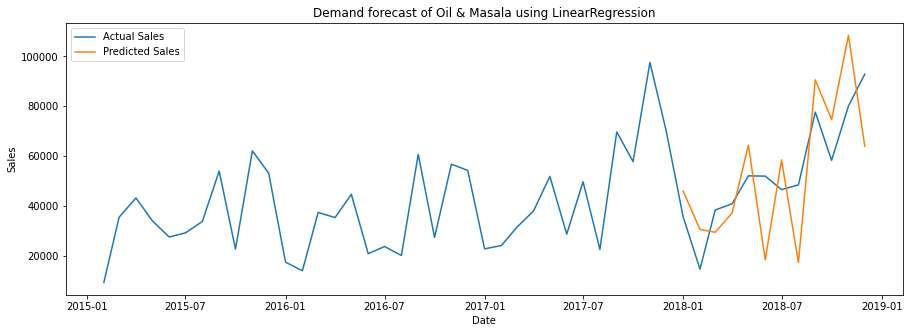

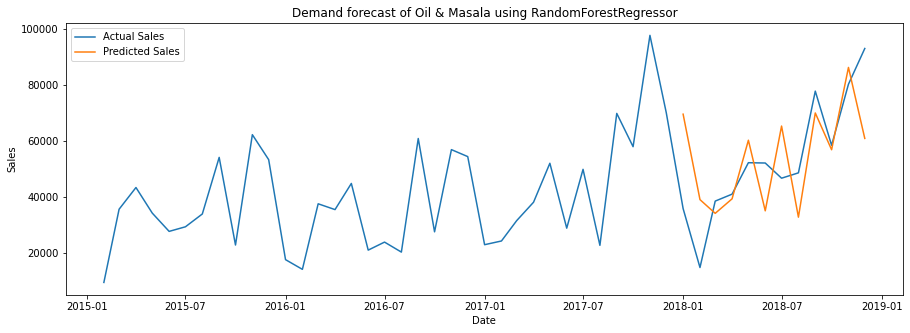

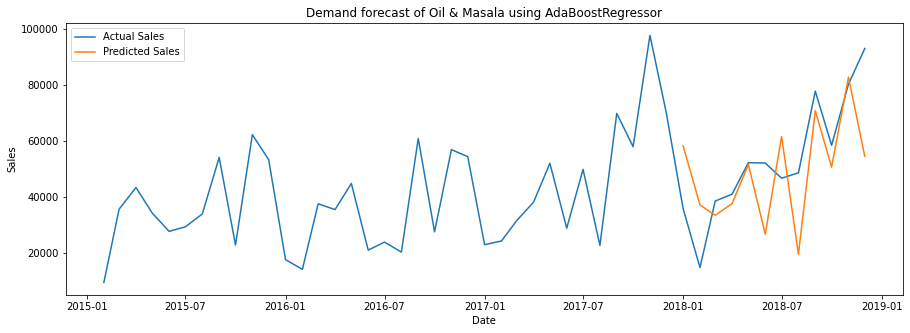

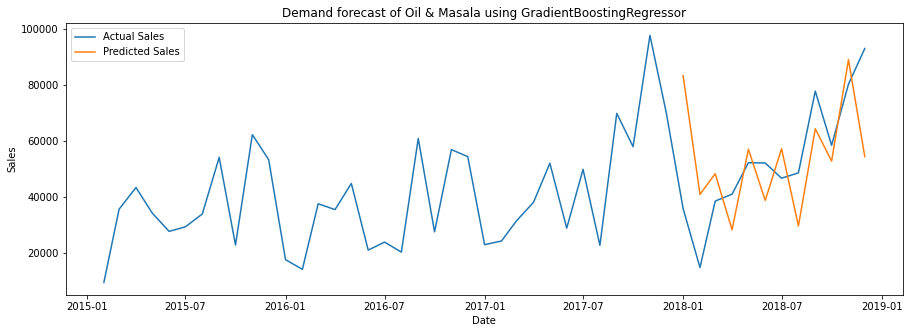

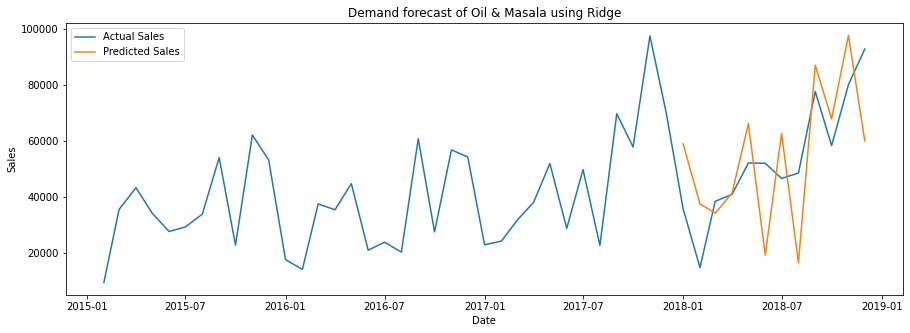

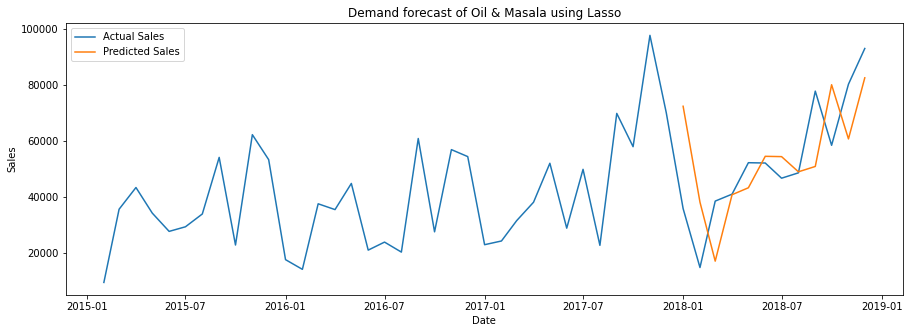

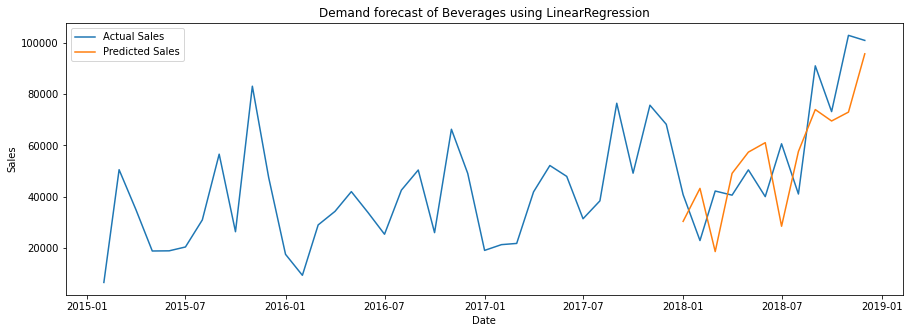

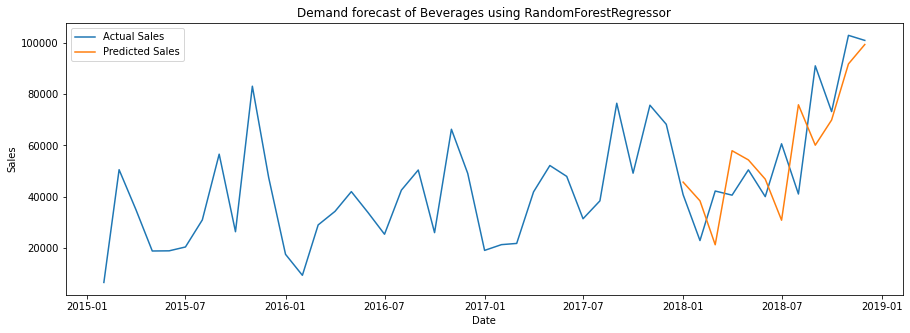

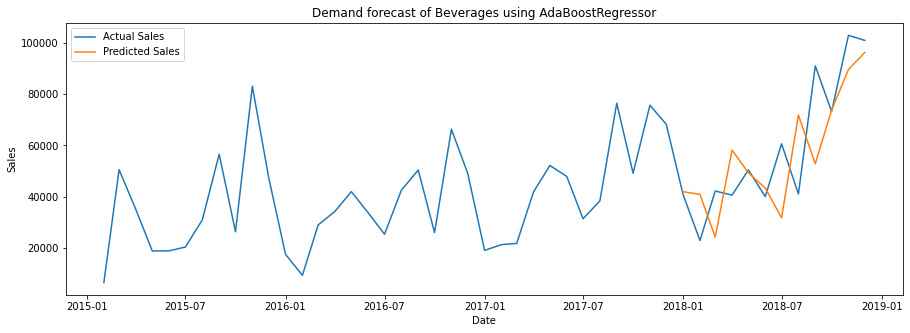

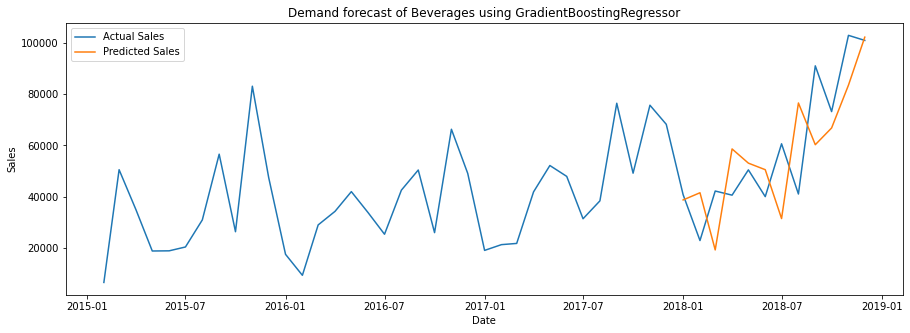

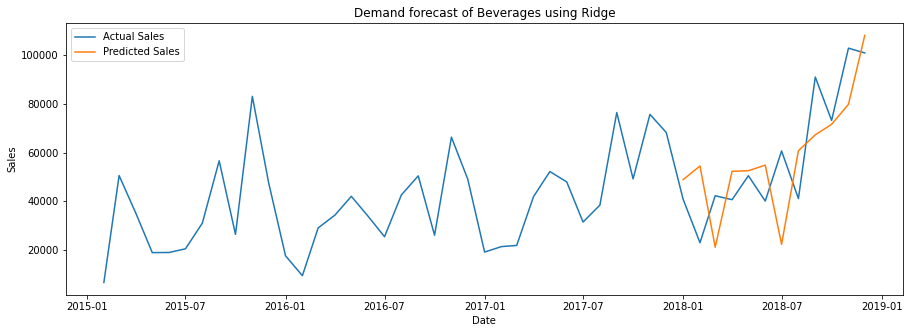

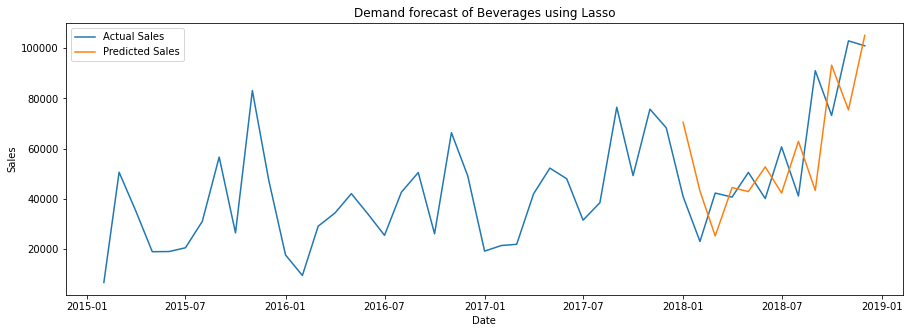

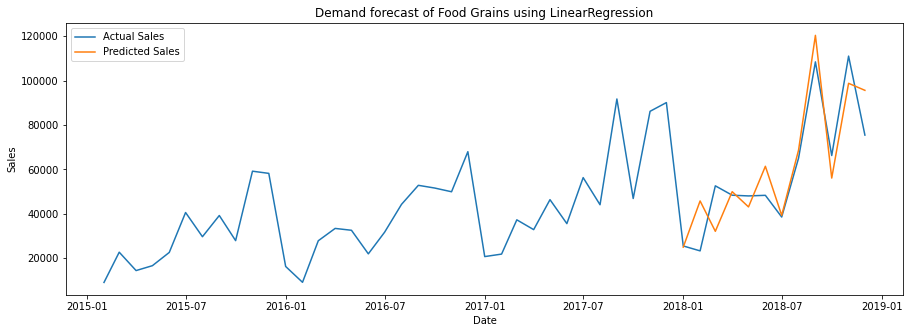

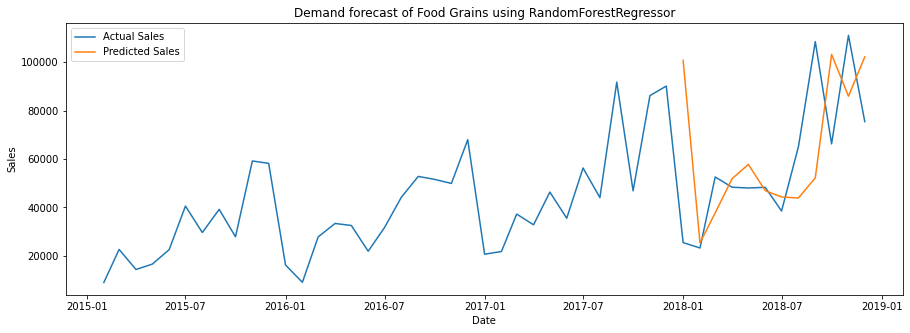

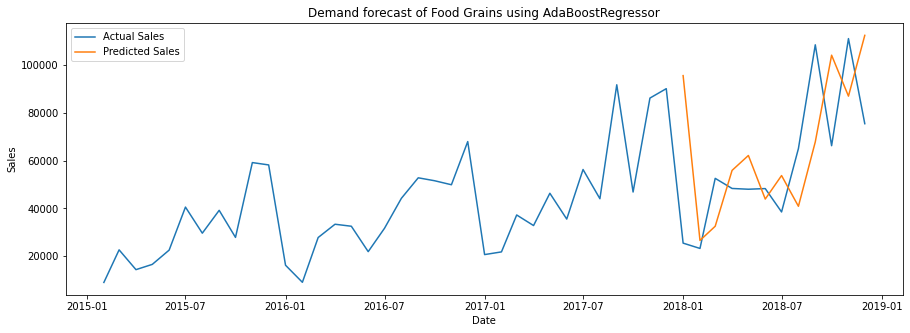

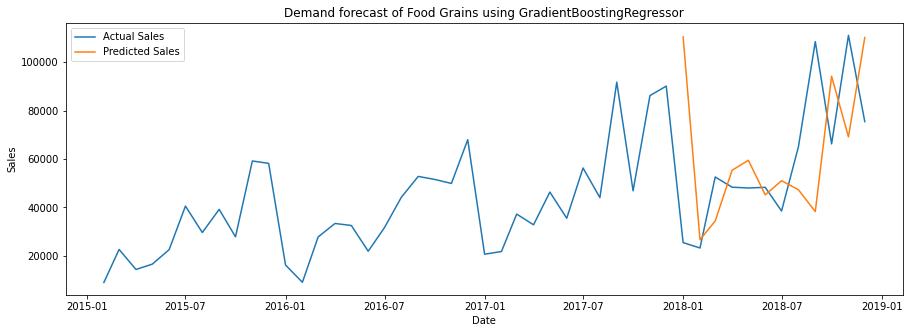

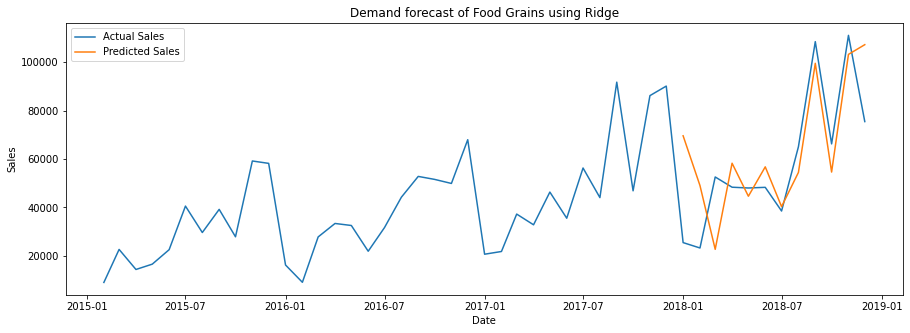

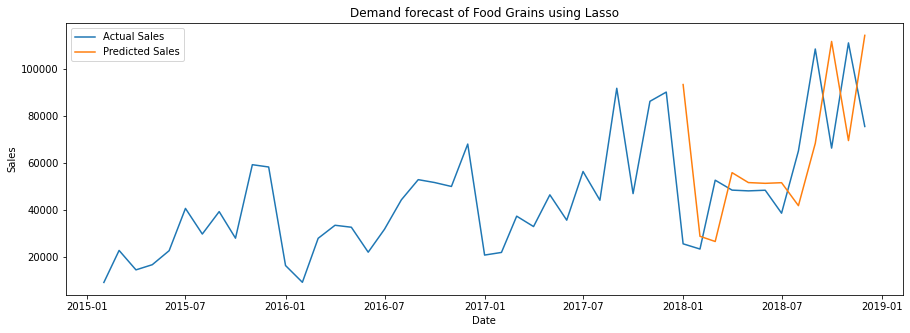

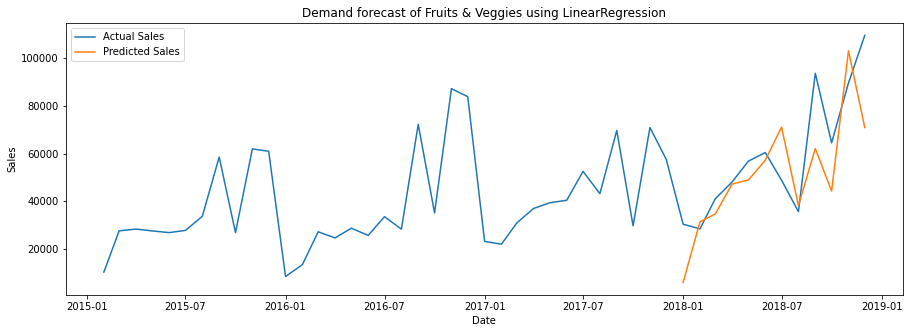

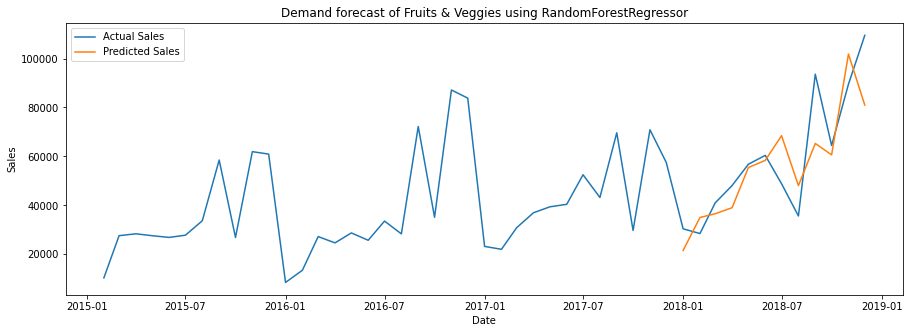

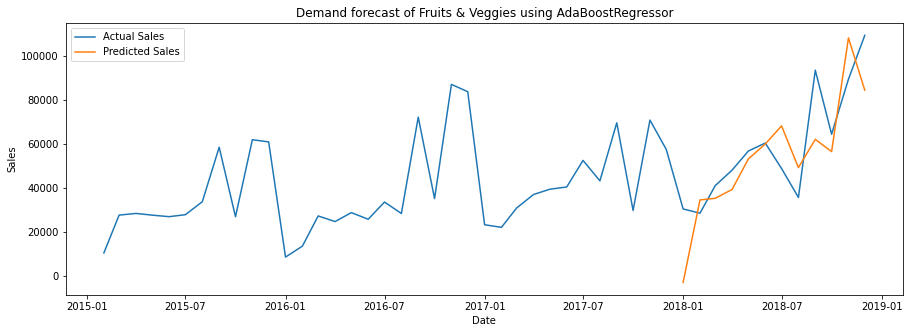

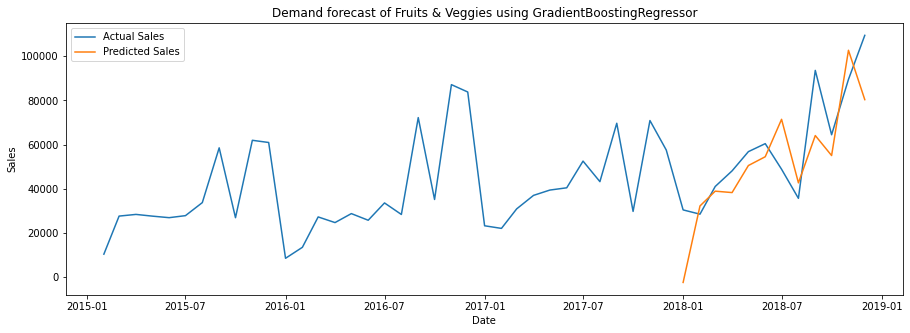

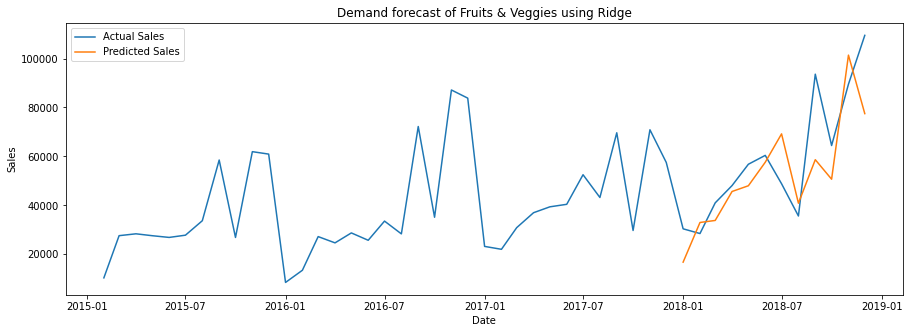

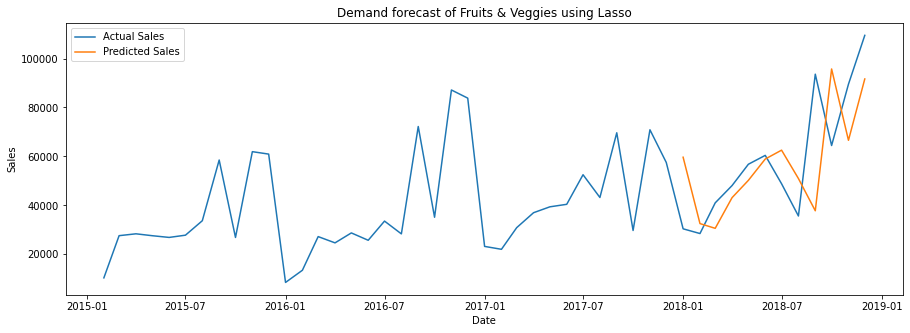

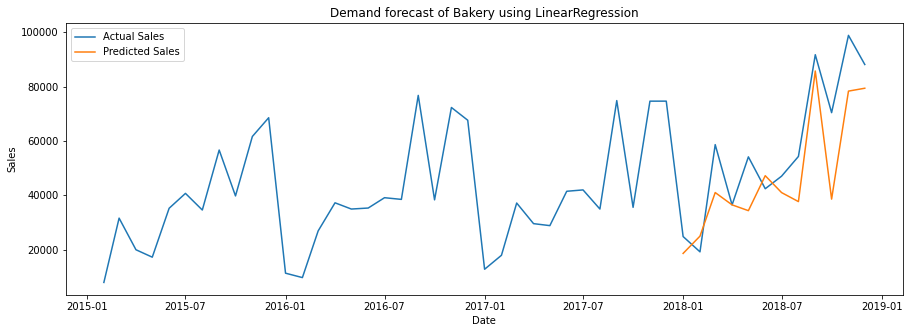

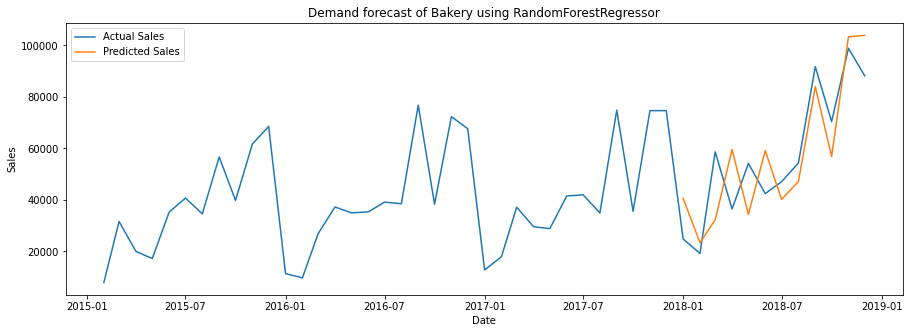

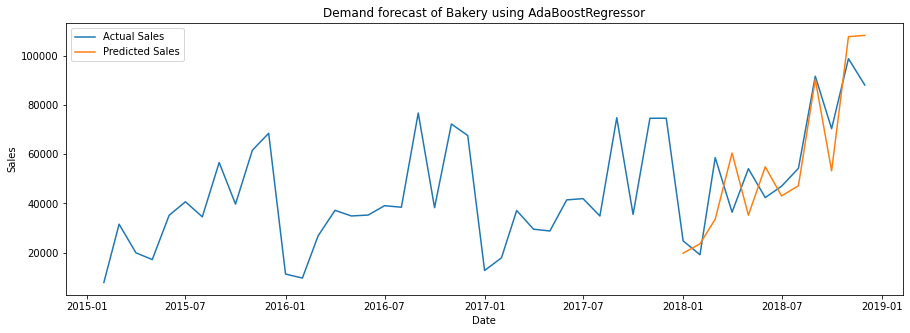

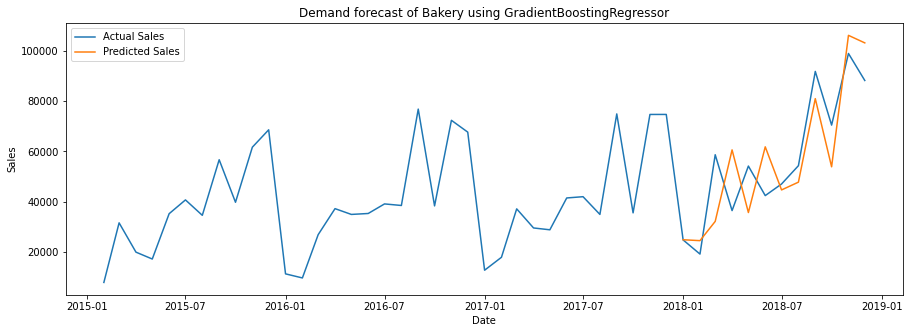

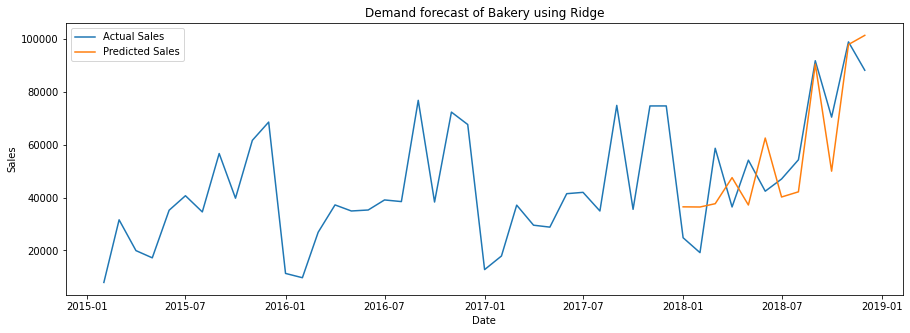

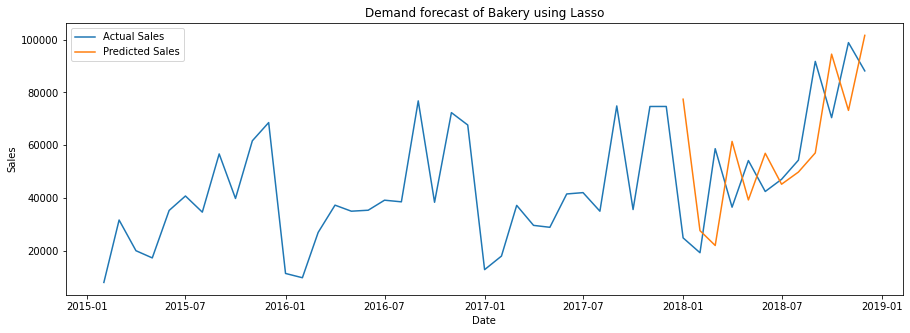

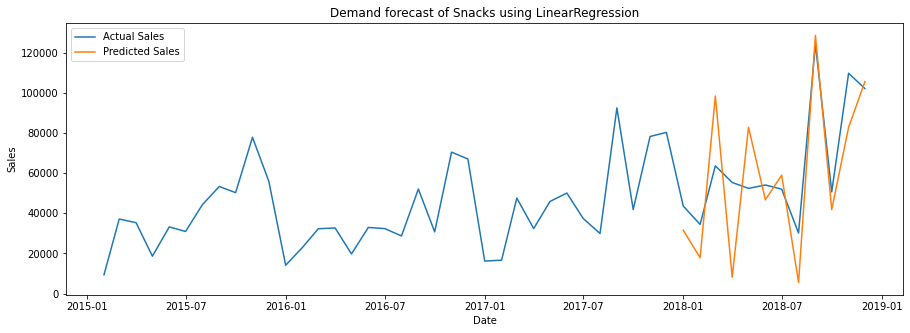

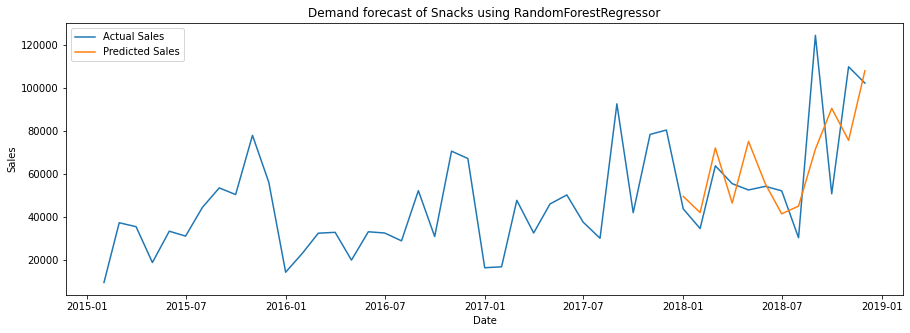

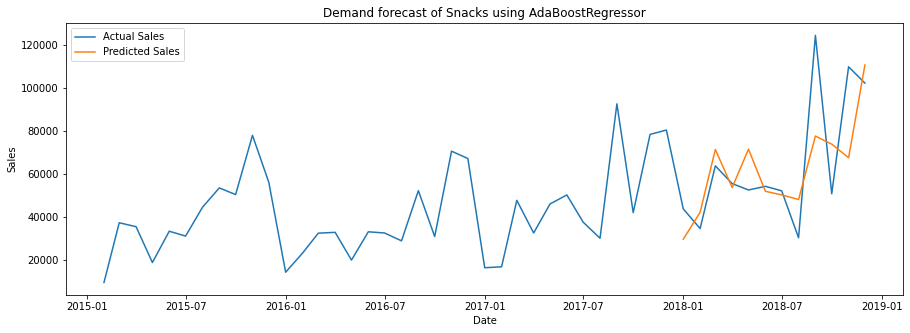

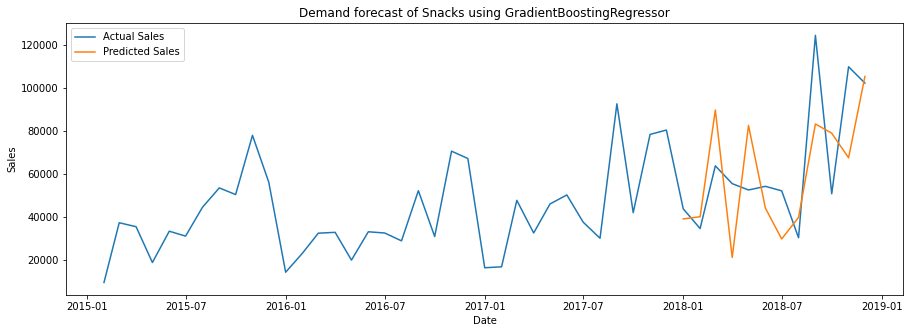

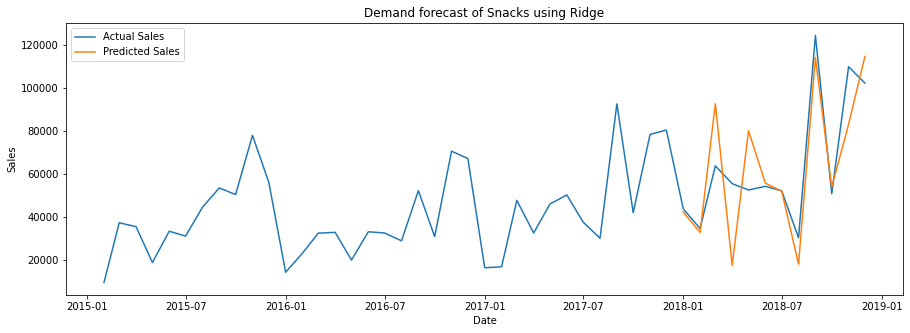

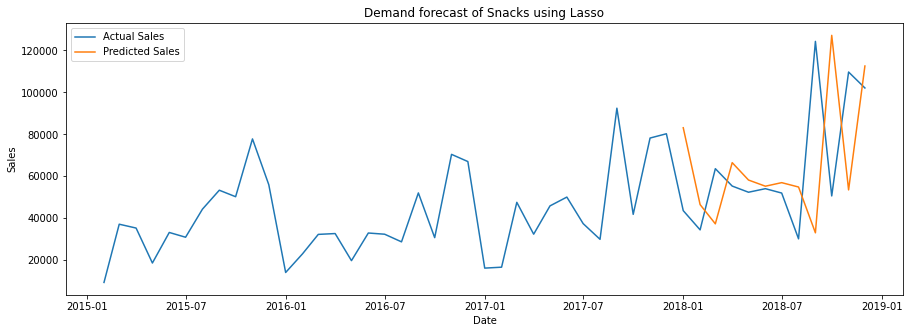

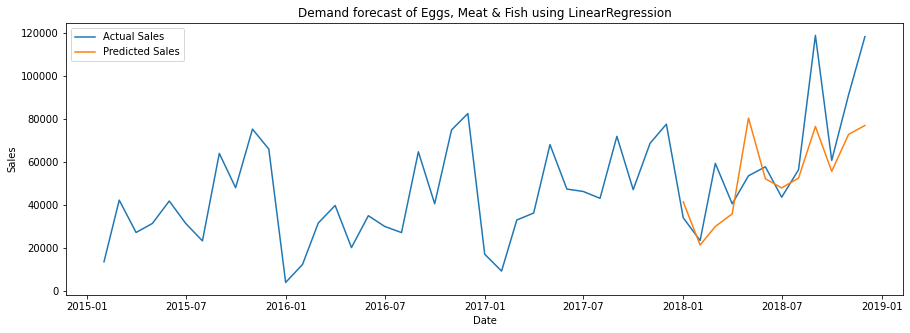

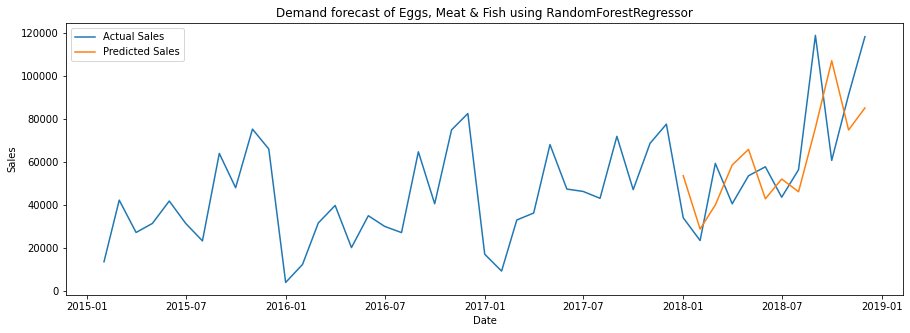

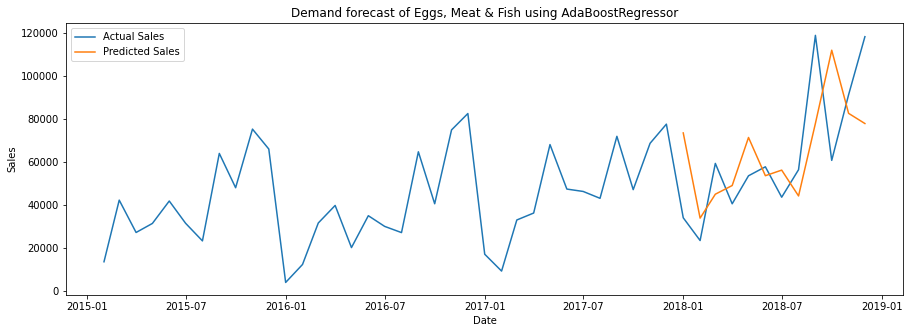

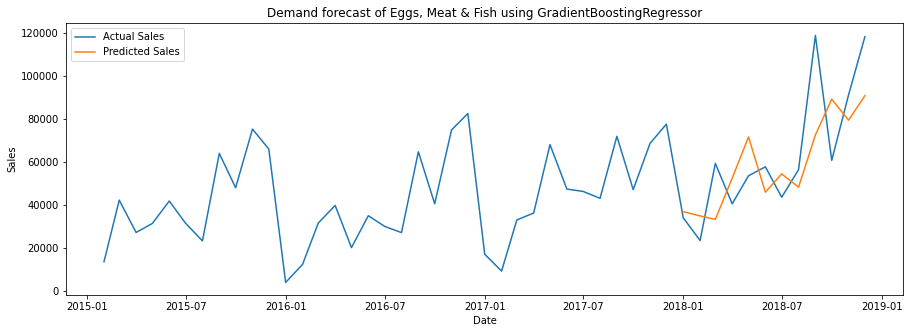

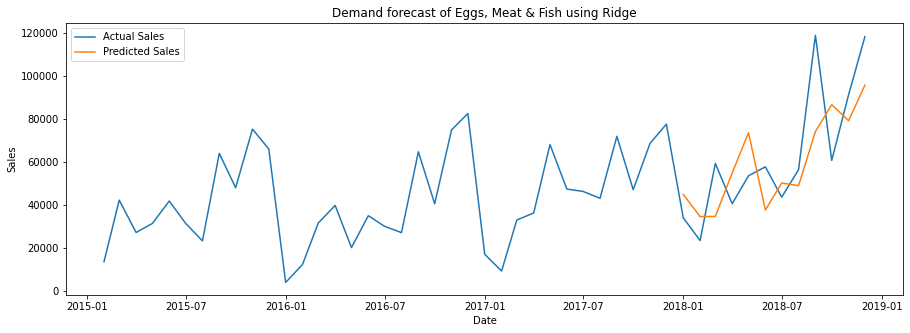

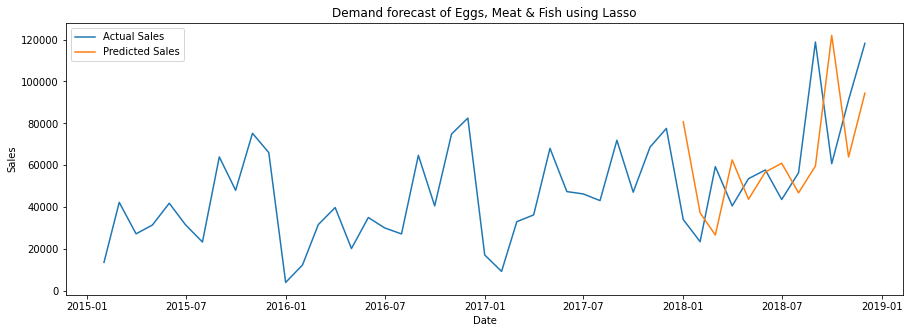

In [ ]:
for cat in categories:
  for model in models:
    fun(cat, model, tables)

In [ ]:
metrics = ['Mean absolute error', 'Mean square error', 'r2', 'Mean absolute percentage error']

In [ ]:
for i in range(0,4):
  tb = pd.DataFrame(tables[i], index=['LinearRegression', 'RandomForestRegressor', 'AdaBoostRegressor', 'GradientBoostingRegressor', 'Ridge', 'Lasso'])
  print(metrics[i])
  print(tb)
  print('_____________________________________________________________________')
  print('\n\n')
  s = '/content/res'+str(i)+'.xlsx'
  print(s)
  tb.to_excel(s)

Mean absolute error
                           Oil & Masala     Beverages   Food Grains  \
LinearRegression           17861.787418  16284.302628  10182.320017   
RandomForestRegressor      14260.508333  15076.494167  23250.504167   
AdaBoostRegressor          14925.362500  14642.902381  24884.769919   
GradientBoostingRegressor  17525.787291  16439.592768  27769.987315   
Ridge                      17960.241717  16917.417318  16188.086679   
Lasso                      14963.250000  19221.648551  26318.873188   

                           Fruits & Veggies        Bakery        Snacks  \
LinearRegression               14523.391508  11998.434025  18614.570277   
RandomForestRegressor          11440.042500  13467.446667  17689.435833   
AdaBoostRegressor              14533.147026  12373.928770  16054.868651   
GradientBoostingRegressor      14302.787299  12685.500694  21438.204621   
Ridge                          13128.595089  12738.078202  13678.557504   
Lasso                          1